In [263]:
from os import path
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

import numpy as np

from datetime import datetime, timezone
from dateutil import tz
import pytz

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

In [264]:
res = pd.read_csv("alameda-county-2018-amy-aggregate-restock.csv")
# res["Timestamp (PST)"] = pd.DatetimeIndex(res['Timestamp (EST)']).tz_convert("America/Los_Angeles")
res.insert(0, "date", pd.DatetimeIndex(res['Timestamp (EST)']).tz_convert("America/Los_Angeles"))
res.insert(1, "year", [t.year for t in res["date"]])
# res.insert(2, "month", [t.month for t in res["date"]])
# res.insert(3, "day", [t.day for t in res["date"]])
# res.insert(4, "hour", [t.hour for t in res["date"]])
# res.insert(1, "date", [t.date for t in res["Timestamp (PST)"]])
res = res.drop(columns="Timestamp (EST)")
res = res[res["year"] == 2018]
res

,date,year,baseline.out.electricity.ceiling_fan.energy_consumption.kwh,baseline.out.electricity.clothes_dryer.energy_consumption.kwh,baseline.out.electricity.clothes_washer.energy_consumption.kwh,baseline.out.electricity.cooling_fans_pumps.energy_consumption.kwh,baseline.out.electricity.cooling.energy_consumption.kwh,baseline.out.electricity.dishwasher.energy_consumption.kwh,baseline.out.electricity.freezer.energy_consumption.kwh,baseline.out.electricity.heating_fans_pumps.energy_consumption.kwh,...,baseline.out.propane.heating_hp_bkup.energy_consumption.kwh,baseline.out.propane.heating.energy_consumption.kwh,baseline.out.propane.hot_water.energy_consumption.kwh,baseline.out.propane.range_oven.energy_consumption.kwh,baseline.out.site_energy.total.energy_consumption.kwh,baseline.out.electricity.total.energy_consumption.kwh,baseline.out.fuel_oil.total.energy_consumption.kwh,baseline.out.natural_gas.total.energy_consumption.kwh,baseline.out.propane.total.energy_consumption.kwh,baseline.upgrade.kwh
11,2018-01-01 00:00:00-08:00,2018,697.337317,2752.061091,279.903451,47.941941,1230.994069,330.266701,544.068386,3339.955190,...,0.0,2032.978735,1140.281870,0.000000,340675.050760,92691.141506,0.0,244752.430899,3231.307189,0
12,2018-01-01 00:15:00-08:00,2018,589.346885,3522.521973,250.605598,50.847513,284.746071,410.412067,544.068386,1539.226848,...,0.0,983.243860,99.488156,0.000000,176963.741715,70483.369281,0.0,105407.062799,1082.732016,0
13,2018-01-01 00:30:00-08:00,2018,578.935251,3199.034940,321.549985,44.067844,229.298069,318.644413,544.068386,1650.849245,...,0.0,1099.904722,65.781399,0.000000,193269.864702,72527.197159,0.0,119581.925243,1165.686121,0
14,2018-01-01 00:45:00-08:00,2018,563.196736,2873.126597,314.770317,40.435879,222.034139,334.140798,544.068386,1757.629021,...,0.0,1205.566537,475.158840,0.000000,200024.627967,71186.759873,0.0,127097.112960,1746.293891,0
15,2018-01-01 01:00:00-08:00,2018,555.690674,2928.090337,205.084968,35.835390,1254.480777,267.796900,544.068386,1860.050440,...,0.0,1292.778337,423.924568,0.000000,207388.880371,72163.032116,0.0,133390.980665,1839.892235,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 20:00:00-08:00,2018,1654.965472,7712.114886,616.949820,86.682903,459.080400,2372.883925,699.516496,1540.921765,...,0.0,1114.309926,2286.098744,176.126679,367859.302411,155724.865918,0.0,208559.108034,3576.535349,0
35036,2018-12-31 20:15:00-08:00,2018,1698.549054,6740.443132,638.257350,102.421418,497.337100,2203.150085,699.516496,1604.117959,...,0.0,1124.244549,1807.604709,176.126679,349968.819893,140017.100730,0.0,206849.430326,3107.975937,0
35037,2018-12-31 20:30:00-08:00,2018,1703.391675,6364.655801,598.547863,85.956510,441.162705,2030.510673,699.516496,1658.597437,...,0.0,1229.054825,1667.739405,82.244489,348508.501230,141611.533449,0.0,203922.122610,2979.038719,0
35038,2018-12-31 20:45:00-08:00,2018,1688.621683,5909.207366,441.889098,87.651427,442.131229,1739.469195,699.516496,1744.311816,...,0.0,1311.512198,1190.380756,0.000000,360949.842870,140597.730898,0.0,217861.179673,2501.892954,0


In [265]:
res_electricity = res[[col for col in res.columns if "baseline.out.electricity" in col]]
res_electricity = res_electricity.rename(columns=dict(zip(res_electricity.columns, [c[25:-23] for c in res_electricity.columns])))
res_electricity["date"] = res["date"]

In [266]:
all_data = pd.read_csv("wattime_data.csv")
df = all_data
df["date"] = [datetime.fromisoformat(s[:-1]) for s in df["point_time"]]
df["date"] = [timestamp.tz_localize("America/Los_Angeles", ambiguous=0, nonexistent="shift_forward") for timestamp in df["date"]]
df["time"] = pd.DatetimeIndex(df['date']).time
df["year"] = [d.year for d in df["date"]]
df["month"] = [d.month for d in df["date"]]
df["day_of_month"] = pd.DatetimeIndex(df['date']).day
df["day_of_week"] = [datetime.weekday(d) for d in df["date"]]
df["day_of_week"] = df["day_of_week"].replace({0 : "Mon", 1 : "Tue", 2 : "Wed", 3 : "Thurs", 4 : "Fri", 5 : "Sat", 6 : "Sun"})
df["hour"] = [d.hour for d in df["time"]]
df["minute"] = [d.minute for d in df["time"]]
df = df.rename(columns = {"value" : "MOER"})
df = df.drop("point_time", axis=1)
data18 = df[df['year'] == 2018]
data18 = data18.sort_values("date")
data18 = data18[data18["minute"] % 15 == 0]
data18 = data18.drop(["frequency", "market", "ba", "datatype", "version"], axis= 1)
data18 = data18.drop_duplicates()
data18

,Unnamed: 0,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute
0,96,1022.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0
3,93,1021.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15
6,90,1018.0,2018-01-01 00:30:00-08:00,00:30:00,2018,1,1,Mon,0,30
9,87,1006.0,2018-01-01 00:45:00-08:00,00:45:00,2018,1,1,Mon,0,45
12,84,1007.0,2018-01-01 01:00:00-08:00,01:00:00,2018,1,1,Mon,1,0
...,...,...,...,...,...,...,...,...,...,...
105117,111,982.0,2018-12-31 22:45:00-08:00,22:45:00,2018,12,31,Mon,22,45
105120,108,1025.0,2018-12-31 23:00:00-08:00,23:00:00,2018,12,31,Mon,23,0
105123,105,1017.0,2018-12-31 23:15:00-08:00,23:15:00,2018,12,31,Mon,23,15
105126,102,1028.0,2018-12-31 23:30:00-08:00,23:30:00,2018,12,31,Mon,23,30


In [267]:
all18 = data18.merge(res_electricity, on= "date")
all18 = all18.drop(['Unnamed: 0'], axis= 1)
# all18 = all18.sort_values(by=['MOER'], ascending= False)
all18

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
0,1022.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0,697.337317,...,205.811361,5519.376435,290.799346,35332.483770,4.600489,313.075399,621.792441,8153.519723,1421.066914,92691.141506
1,1021.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15,589.346885,...,178.692687,3875.306859,217.917911,34428.608700,4.600489,313.075399,552.300840,8096.376804,961.502252,70483.369281
2,1018.0,2018-01-01 00:30:00-08:00,00:30:00,2018,1,1,Mon,0,30,578.935251,...,178.692687,3843.345565,217.917911,34297.373691,4.600489,313.075399,470.218427,8096.376804,961.502252,72527.197159
3,1006.0,2018-01-01 00:45:00-08:00,00:45:00,2018,1,1,Mon,0,45,563.196736,...,178.692687,3747.703815,217.917911,34041.199079,4.600489,313.075399,288.862298,8096.376804,961.502252,71186.759873
4,1007.0,2018-01-01 01:00:00-08:00,01:00:00,2018,1,1,Mon,1,0,555.690674,...,178.692687,3724.217107,217.917911,33964.443548,4.600489,313.075399,196.368251,8096.376804,961.502252,72163.032116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35044,984.0,2018-12-31 20:00:00-08:00,20:00:00,2018,12,31,Mon,20,0,1654.965472,...,260.048708,44433.704277,468.765641,56089.649098,12.348682,851.816903,3204.361822,9681.850675,1662.471533,155724.865918
35045,968.0,2018-12-31 20:15:00-08:00,20:15:00,2018,12,31,Mon,20,15,1698.549054,...,301.695242,36532.485069,415.254687,53318.701789,5.811144,418.644521,2690.559813,9587.903842,1769.251310,140017.100730
35046,961.0,2018-12-31 20:30:00-08:00,20:30:00,2018,12,31,Mon,20,30,1703.391675,...,301.695242,36826.189988,415.254687,53556.474443,5.811144,418.644521,2224.699745,9587.903842,1769.251310,141611.533449
35047,960.0,2018-12-31 20:45:00-08:00,20:45:00,2018,12,31,Mon,20,45,1688.621683,...,301.695242,36507.545575,415.254687,53342.672759,5.811144,418.644521,2183.779604,9587.903842,1769.251310,140597.730898


In [268]:
def get_extreme_peaks_by_percentile(percentile, waking_hours_only=False, rolling=True):  
    """
    Returns all extreme peaks where the peak MOER is in the specified percentile of all MOER data
    
    percentile - int in [0, 100] that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = all18[~all18["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = all18
    
    data = data.reset_index(drop=True)
    
    moers = data["MOER"]

    cutoff = np.percentile(moers, percentile)
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
    
    return data.iloc[peak_indices]

In [269]:
def get_extreme_peaks_by_value(cutoff, waking_hours_only=False):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    cutoff - MOER cutoff that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = all18[~all18["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = all18
    
    data = data.reset_index(drop=True)
    
    moers = data["MOER"]
    
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [270]:
def get_top_n_peaks(n, waking_hours_only=False):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    n - number of peaks to return
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    return get_extreme_peaks_by_percentile(99, waking_hours_only).sort_values(by=["MOER"], ascending=False).head(n)

In [271]:
df = all18
top_100_peaks = get_top_n_peaks(100, waking_hours_only=True)

<AxesSubplot:xlabel='date', ylabel='MOER'>

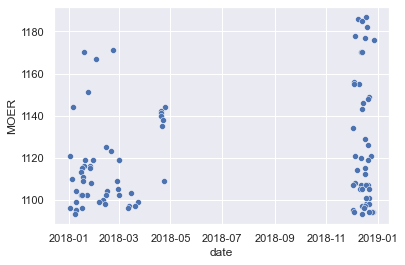

In [272]:
sns.scatterplot(data=top_100_peaks, x="date", y="MOER")

<AxesSubplot:xlabel='hour', ylabel='MOER'>

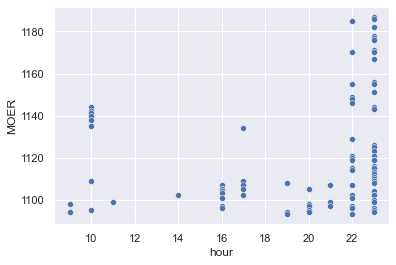

In [273]:
sns.scatterplot(data=top_100_peaks, x="hour", y="MOER")

In [274]:
all18.columns

Index(['MOER', 'date', 'time', 'year', 'month', 'day_of_month', 'day_of_week',
       'hour', 'minute', 'ceiling_fan', 'clothes_dryer', 'clothes_washer',
       'cooling_fans_pumps', 'cooling', 'dishwasher', 'freezer',
       'heating_fans_pumps', 'heating_hp_bkup', 'heating', 'hot_tub_heater',
       'hot_tub_pump', 'hot_water', 'lighting_exterior', 'lighting_garage',
       'lighting_interior', 'mech_vent', 'plug_loads', 'pool_heater',
       'pool_pump', 'range_oven', 'refrigerator', 'well_pump', 'total'],
      dtype='object')

In [275]:
def get_pie(timestamp):
    df = all18.loc[all18["date"] == timestamp]
    print("Timestamp: " + timestamp)
    print("MOER: " + str(df["MOER"]))
    df = df.drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])
    to_plot = pd.DataFrame({"MOER": df.values[0], "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:3], "Appliance" : df.columns})
    to_plot = to_plot.sort_values(by="MOER")
    plt.pie(to_plot["MOER"], labels = to_plot["Appliance"], colors = to_plot["color"], autopct='%.0f%%')

In [276]:
sns.set(rc={'figure.figsize':(20,8.27)})
all18[all18["date"] == "2018-02-04 16:00:00-08:00"]

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
3330,75.0,2018-02-04 16:00:00-08:00,16:00:00,2018,2,4,Sun,16,0,773.850717,...,123.002554,17117.209814,274.334437,48427.17107,93.704702,6431.726091,2590.801836,8149.161364,727.603693,122906.912715


In [277]:
top_100_peaks.sort_values("MOER", ascending=False)

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
22473,1187.0,2018-12-17 23:15:00-08:00,23:15:00,2018,12,17,Mon,23,15,825.424622,...,205.811361,6853.276184,290.799346,36906.577484,4.600489,313.075399,613.075724,8153.519723,1421.066914,83480.719913
21833,1186.0,2018-12-07 23:15:00-08:00,23:15:00,2018,12,7,Fri,23,15,843.584448,...,205.811361,7010.177080,290.799346,37069.531656,4.600489,313.075399,1120.824458,8153.519723,1421.066914,83939.316051
22149,1185.0,2018-12-12 22:15:00-08:00,22:15:00,2018,12,12,Wed,22,15,1186.199831,...,232.930034,18345.540441,306.537862,42983.339510,4.600489,313.075399,1148.669524,8876.522927,1640.195480,105826.022554
22539,1182.0,2018-12-18 23:45:00-08:00,23:45:00,2018,12,18,Tue,23,45,718.160584,...,205.811361,5805.575292,290.799346,35588.658382,4.600489,313.075399,351.816361,8153.519723,1421.066914,74081.920392
21641,1178.0,2018-12-04 23:15:00-08:00,23:15:00,2018,12,4,Tue,23,15,823.971836,...,205.811361,6804.123589,290.799346,36913.357152,4.600489,313.075399,349.637182,8153.519723,1421.066914,89421.888572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22866,1094.0,2018-12-24 09:30:00-08:00,09:30:00,2018,12,24,Mon,9,30,689.346993,...,54.237347,14933.672341,303.148028,42913.847910,184.988094,12689.602115,2466.830758,8153.519723,699.032234,122323.861237
22864,1094.0,2018-12-24 09:00:00-08:00,09:00:00,2018,12,24,Mon,9,0,757.627939,...,123.002554,14335.850871,284.261809,42715.542610,128.087306,8798.556740,3386.686475,8153.519723,718.402715,121984.635688
22652,1094.0,2018-12-20 20:00:00-08:00,20:00:00,2018,12,20,Thurs,20,0,1639.226956,...,260.048708,43665.664704,468.765641,55877.058069,12.348682,851.816903,3456.420207,9681.850675,1662.471533,154128.738283
22138,1093.0,2018-12-12 19:30:00-08:00,19:30:00,2018,12,12,Wed,19,30,1579.178465,...,260.048708,41700.045143,468.765641,54889.163537,12.348682,851.816903,4867.317618,9681.850675,1662.471533,144068.678966


## Average energy consumption during a top 100 peak

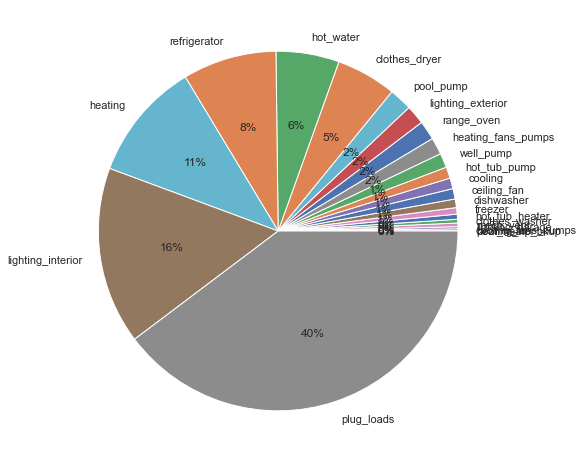

In [281]:
means = top_100_peaks.mean().drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])[6:-1]
to_plot = pd.DataFrame({"Appliance": means.index, "Value": means, "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:3]})
to_plot = to_plot.sort_values(by="Value")
plt.pie(to_plot["Value"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%');

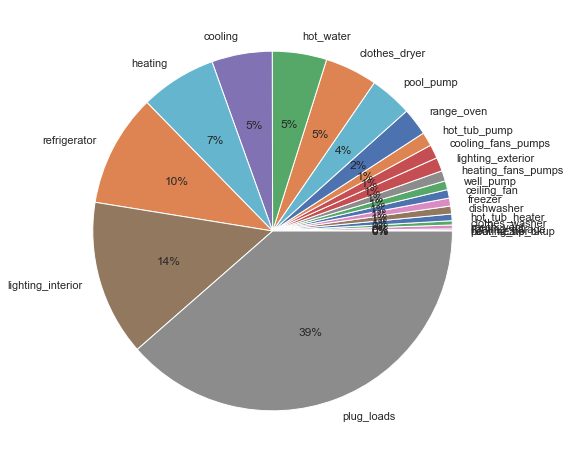

In [283]:
all_means = all18.mean().drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])[6:-1]
to_plot = pd.DataFrame({"Appliance": all_means.index, "Value": all_means, "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:3]})
to_plot = to_plot.sort_values(by="Value")
plt.pie(to_plot["Value"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%');

In [312]:
means = means.sort_values(ascending=False)

In [313]:
df = pd.DataFrame({"kWH" : means})
df2 = pd.DataFrame({"kWH" : all_means})

In [314]:
combined = pd.merge(df, df2, left_index=True, right_index=True).rename(columns={"kWH_x" : "2018 Top 100 Peak Average Load Profile", "kWH_y" : "2018 Average Load Profile"})
combined["Use"] = combined.index
combined = combined.melt(id_vars=["Use"])

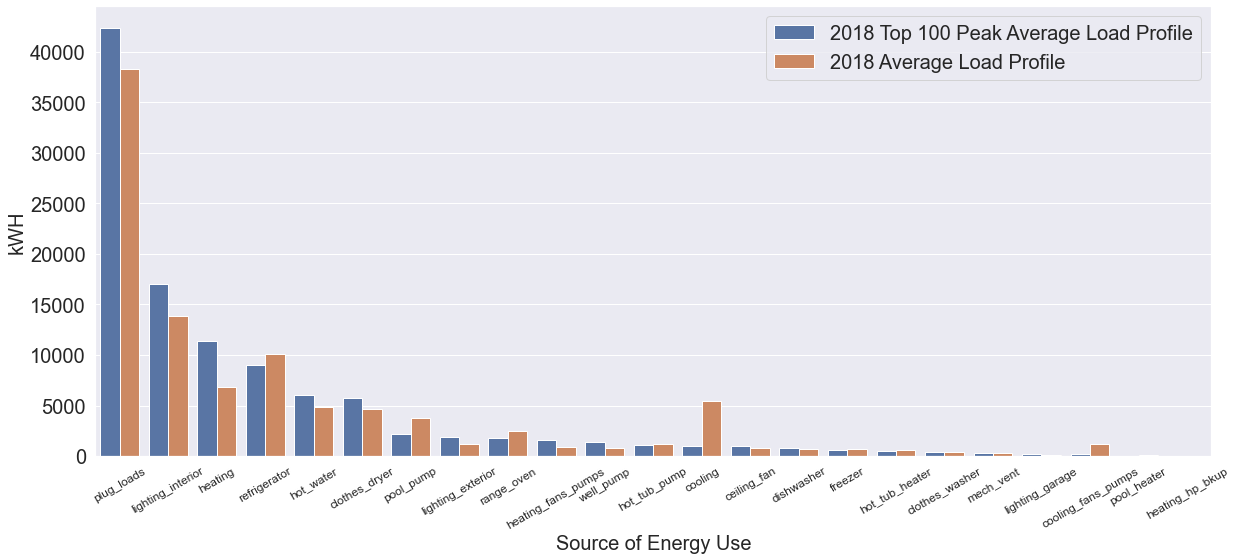

In [326]:
sns.barplot(data=combined, x="Use", y="value", hue="variable")
plt.xlabel("Source of Energy Use", fontsize=20)
plt.ylabel("kWH", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=30, fontsize=12)
plt.legend(loc=1, prop={'size': 20});

In [331]:
sum(df["kWH"])

106669.32855127174

In [332]:
sum(df2["kWH"])

99325.24552525248